# Librerias

In [1]:
# from oficial python
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch
from matplotlib import cm
import matplotlib as mpl
from qutip import basis, tensor
import time
from sklearn.model_selection import train_test_split
import pennylane as qml
import os
import pandas as pd

# own modules:
from dll.spin_procesor_modificated import Quantum_Spin_Proces
from dll.main_fun import make_IRIS_v2, pulse_x_with_noise, pulse_x, pulse_z
from dll. baseline_dru_v2 import Modelo_DRU
from dll.models import qcircuit_1_qubit_mixed, qcircuit_2_qubit_mixed, qcircuit_4_qubit_mixed
from dll.cost_functions import fidelity_cost
from dll.gate_procesor_modificated import CompositeGateProcessor

In [2]:
def calculate_fidelity(state_base_line, state_spins):
  # convert spin to dm
  nf, nc = state_spins.shape
  if nc == 1:
    dm_spin = state_spins @ state_spins.conj().T
  # calculare fidelity:
  F  = qml.math.fidelity(state_base_line, dm_spin)
  return F
  

# Proceso general

In [3]:
# Base line parameters
N_layeres = 5
n_classes = 3
n_features = 3
Epocas = 10
# Spin processor parameters:

configuration_cases = {
            # MODEL entanglement, floss, Nlayers, Nqubits
  "case_1": [1, False],
  "case_2": [2, False],
  "case_3": [2, True],
  "case_4": [4, False],
  "case_5": [4, True]
}

Results_fidel = []

for key_case in configuration_cases:
  
  N_qubits, entan = configuration_cases[key_case]
  
  
  if entan == False:
    N_true_layer = N_layeres
  else:
    if N_qubits == 2:
      N_true_layer = 2*N_layeres
    else:
      N_true_layer = 2*N_layeres - 1
  
  #entan = False

  ket0 =  tensor([basis(2, 0)]*N_qubits)

  nombre_funcion = f"qcircuit_{N_qubits}_qubit_mixed"
  model_circuit = globals().get(nombre_funcion)

  model = Modelo_DRU(model_circuit, fidelity_cost,
                    epochs = Epocas, n_clases = n_classes, n_qubits = N_qubits,
                    features = n_features, alpha_noise = 0.0, save_process=False,
                    num_layers = N_layeres, entanglement = entan)

  X, y =  make_IRIS_v2(n_features, n_classes)

  # splita data:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

  # get optimized parameters
  paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

  # TRAIN =================================

  # Train proces
  Fidel_intra_states_train = np.zeros((len(model.X_train), N_true_layer))


  for i, x_train_point in enumerate(model.X_train):
    
    # Intra states del base line:
    states_base_line = qml.snapshots(model_circuit)(paramters_1q, x_train_point, bias=bias_1q,  entanglement=entan)
    
    # Generar intra states de spin processor:
    dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=5, n_points_pulse_Ri_spl = 100, version_qutip="5",
                                      N_qubits = N_qubits, tf_noise = False, tf_quantum_noise = False,
                                      ket_dru_0 = ket0, save_intra_states=True)                        
    #state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q, x_train_point, bias=bias_1q)
    metodo = getattr(dru_circuit, f"qcircuit_DRU_{N_qubits}_Qubit", None)
    state_dru = metodo(paramters_1q, x_train_point, bias=bias_1q,  entanglement=entan)
    # Por cada intra state calcular fidelidad:
    for j, key in enumerate(dru_circuit.dict_states):
      # get intra-state de base line:
      state_base_line = states_base_line[key]
      # get intra-state de QIUP:
      state_spin = dru_circuit.dict_states[key]
      # calcule fidelity:
      F = calculate_fidelity(state_base_line, state_spin)
      # save fidelity:
      Fidel_intra_states_train[i,j] = F

  # Calcula el promedio de cada columna
  mean_train = np.mean(Fidel_intra_states_train, axis=0)
  # Calcula la desviación estándar de cada columna
  std_dev_train = np.std(Fidel_intra_states_train, axis=0)

  # Test =================================

  # Train proces
  Fidel_intra_states_test = np.zeros((len(model.X_val), N_true_layer))

  for i, x_test_point in enumerate(model.X_val):
    
    # Intra states del base line:
    states_base_line = qml.snapshots(model_circuit)(paramters_1q, x_test_point, bias=bias_1q,  entanglement=entan)
    
    # Generar intra states de spin processor:
    dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=5, n_points_pulse_Ri_spl = 100, version_qutip="5",
                                      N_qubits = N_qubits, tf_noise = False, tf_quantum_noise = False,
                                      ket_dru_0 = ket0, save_intra_states=True)                        
    metodo = getattr(dru_circuit, f"qcircuit_DRU_{N_qubits}_Qubit", None)
    state_dru = metodo(paramters_1q, x_test_point, bias=bias_1q,  entanglement=entan)
    
    # Por cada intra state calcular fidelidad:
    for j, key in enumerate(dru_circuit.dict_states):
      # get intra-state de base line:
      state_base_line = states_base_line[key]
      # get intra-state de QIUP:
      state_spin = dru_circuit.dict_states[key]
      # calcule fidelity:
      F = calculate_fidelity(state_base_line, state_spin)
      # save fidelity:
      Fidel_intra_states_test[i,j] = F

  # Calcula el promedio de cada columna
  mean_test = np.mean(Fidel_intra_states_test, axis=0)
  # Calcula la desviación estándar de cada columna
  std_dev_test = np.std(Fidel_intra_states_test, axis=0)
  
  # save results:
  df = pd.DataFrame({
    "States": list(dru_circuit.dict_states.keys()),
    "Mean Fidel train": mean_train.tolist(),
    "Mean Fidel test": mean_test.tolist(),
    "Std Fidel train": std_dev_train.tolist(),
    "Std Fidel test": std_dev_test.tolist()
  })
  path_save_excel = os.path.join("results_of_test","test_3")
  df.to_excel(os.path.join(path_save_excel, f"Fidelity_result_intra_states_q_{N_qubits}_engl_{entan}.xlsx"), index=False)


Epoch: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Epoch: 100%|██████████| 10/10 [00:41<00:00,  4.15s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Epoch: 100%|██████████| 10/10 [00:41<00:00,  4.12s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Epoch: 100%|██████████| 10/10 [01:21<00:00,  8.15s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarni

# Pulsos

In [3]:
def make_total_pulse(B0_pulses):
  # Convertir el array a tipo float para poder asignar NaN
  B0_pulses = B0_pulses.astype(float)

  # Crear un vector complementario donde los ceros se reemplazan por unos
  B0_complement = np.where(B0_pulses == 0, np.max(B0_pulses), B0_pulses)

  # Crear una máscara para los valores que son cero en el vector original
  mask = B0_pulses == 0

  # Crear una copia del vector original para graficar los valores reales mayores que cero
  B0_pulses_real = np.copy(B0_pulses)
  B0_pulses_real[mask] = np.nan  # Reemplazar los ceros con NaN para no plotearlos

  # Crear una copia del vector complementario para graficar los valores complementados
  B0_pulses_complement = np.copy(B0_complement)
  B0_pulses_complement[~mask] = np.nan  # Reemplazar los valores no complementados con NaN
  
  return B0_complement, B0_pulses_complement

In [5]:
def plot_pulses_v2(self, verbose = 1, key_show = 'all', entangl = False):
  # Tomar todos los pulsos:
  resultado = self.pulse_type
  # Definir el tiempo global de simulacion:
  glob_time = self.global_time
  # Por cada pulso...
  for key in resultado:
    # Identificar su tipo:
    list_pulses = resultado[key]
    # Caso pulso unitario:
    if list_pulses[0]['Type_pulse'] == 'Unitary':
      print(key)
      global_time_sim = np.linspace(0, glob_time , 1000) # Tiempo total de simulacion
      B1_pulses = np.zeros(len(global_time_sim )) # vect. para guardar pulso Bx
      B0_pulses = np.zeros(len(global_time_sim )) # vect. para guardar pulso B0
      for dict_pulse in list_pulses:
        # B0 results
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        B0_i = dict_pulse['B0'] * pulse_z(
                                  global_time_sim,
                                  args2)
        # Se guarda reiterativamente los pulsos cuadrados:
        B0_pulses += np.array(B0_i)
        # B1 results
        # Correccion desviacion estandar:
        if self.tf_noise == True:
          if dict_pulse['B1'] != 0:
            dv = self.noise_std/abs(dict_pulse['B1'])
          else:
            dv = 0
        else:
          dv = 0
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f'], "std_noise": dv }
        B1_i = dict_pulse['B1'] * pulse_x_with_noise(
                                  global_time_sim,
                                  args2)
        # Se guarda reiterativamente los pulsos cuadrados:
        B1_pulses += np.array(B1_i)
      # Plot
      # =================================================================
      # Extrar informacion de las I virtuales:
      B0_pulses_blue, B0_pulses_red = make_total_pulse(np.abs(B0_pulses))
      # poner inicio en 0
      B0_pulses_blue[0] = 0
      B0_pulses_blue[-1] = 0
      B0_pulses_red[0] = 0
      B0_pulses_red[-1] = 0 
      # Graficar los valores reales mayores que cero en azul
      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim* 1e9, np.abs(B0_pulses),linewidth=0.5, color='darkblue') # BORRAR
      plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')
      plt.plot(global_time_sim* 1e9, B0_pulses_red, 'r-', label=r'Virtual $I$ gate')
      plt.title("Pulse sequence for B0")
      plt.xlabel("time [ns]")
      plt.ylabel("B0 [T]")
      plt.grid()
      if self.N_qubits > 1:
        plt.legend()
      plt.rcParams['text.usetex'] = True
      plt.rcParams['font.family'] = 'Times New Roman'
      path_to_save_img = os.path.join("results_of_test","test_3",f"B0_PSeq_{self.N_qubits}_entgl_{entangl}_q_obj_{key}.pdf")
      plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
      plt.show()

      # Grafica para B1:
      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim* 1e9, B1_pulses,linewidth=1.7, color='darkblue')
      plt.title("Pulse sequence for B1")
      plt.xlabel("time [ns]")
      plt.ylabel("B1 [T]")
      plt.grid()
      plt.rcParams['text.usetex'] = True
      plt.rcParams['font.family'] = 'Times New Roman'
      path_to_save_img = os.path.join("results_of_test","test_3", f"B1_PSeq_{self.N_qubits}_entgl_{entangl}_q_obj_{key}.pdf")
      plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
      plt.show()

    elif list_pulses[0]['Type_pulse'] == "Two_Qubits":
      # Tiempo global de simulación:
      global_time_sim = np.linspace(0, glob_time, 100000)
      # vector para definir el pulso, inicializandolo en 0:
      J_pulses = np.zeros(len(global_time_sim ))
      # def figura:
      fig, ax = plt.subplots(figsize=(8,3))
      # por cada pulso...
      for th, dict_pulse in enumerate(list_pulses):
        t_i = dict_pulse['t_i'] # t inicial
        t_f = dict_pulse['t_f'] # tiempo final
        J = dict_pulse['J'] # amplitud de J
        duration = t_f - t_i # duracion pulso
        Swap_time = np.pi/(J) # tiempo esperado para SWAP
        sqrt_Swap_time = np.pi/(2*J) # tiempo esperado para sqrt SWAP
        # identificar tipo de pulso
        label = "SWAP" if abs(duration - Swap_time) < 1e-13 else r"$\sqrt{SWAP}$" if abs(duration - sqrt_Swap_time) < 1e-13 else "Unknown"
        #print(f"Duracion real = {duration}, swap = {Swap_time}, sqrt swap = {sqrt_Swap_time}, label = {label}")
        args2 = {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        J_i = dict_pulse['J'] * pulse_x(
                                  global_time_sim,
                                  args2)
        # Actualizar pulsos de forma reiterativa:
        J_pulses += np.array(J_i)
        
        # Añadir el texto sobre el pulso
        t_center = (t_f + t_i) / 2 # Definir centro
        # Posicion en y del texto:
        if label == "SWAP":
          y_text = dict_pulse['J']*1.05
        else:
          y_text = dict_pulse['J']*1.05
        # add text:
        ax.text((t_center*1e9)*np.random.uniform(0.99, 1.00), y_text*1e-12,
                label, horizontalalignment='center',
                verticalalignment='bottom', rotation=90, fontsize=5)
      # Plot
      # ==================================================================
      ax.plot(global_time_sim*1e9, J_pulses*1e-12, linewidth=1.7, color='darkblue')
      ax.set_xlabel("time [ns]")
      ax.set_ylabel("J [meV]")
      ax.set_ylim([0, (np.max(J_pulses)*1e-12)*1.30])
      plt.rcParams['text.usetex'] = True
      plt.rcParams['font.family'] = 'Times New Roman'
      plt.grid()
      path_to_save_img = os.path.join("results_of_test","test_3", f"J_PSeq_{self.N_qubits}_entgl_{entangl}_q_obj_{key}.pdf")
      plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
      plt.show()
  

In [ ]:
"""
x1, x2, y1, y2 = (save_t_i*1e9)*0.99999991, (save_t_f*1e9)*1.00007, 0, J*1.2
# Añadir la inserción (inset) en la gráfica principal
axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
axins.plot(global_time_sim*1e9, J_pulses, drawstyle='steps-post', color='blue')

# Definir el área de zoom
# Quitar los xlabels y ylabels
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])

# Añadir el texto específico
#axins.text(13.795, 0.8e12, r'$\Delta t = 1.2 \, \mathrm{ps}$', fontsize=10)

# Añadir una caja de zoom y las líneas de conexión
ax.indicate_inset_zoom(axins, edgecolor="black")
"""

Epoch: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_18020\2242180939.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


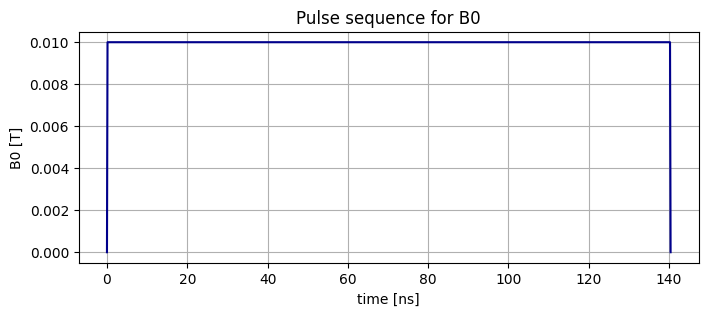

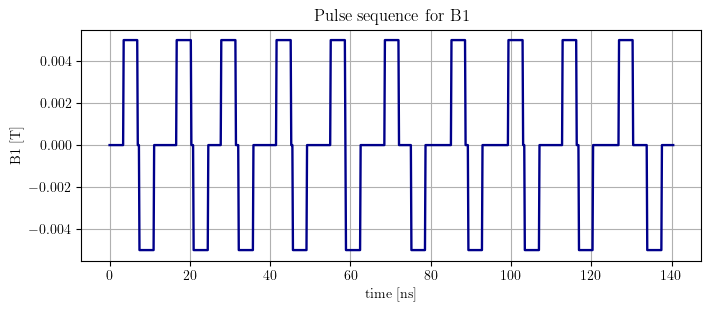

In [5]:
# Pulsos para 1qubit:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                        epochs = 5, n_clases = 3, n_qubits = 1,
                        features = 3, num_layers = 10, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = False)

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 1,
                                     tf_noise = False,
                                     noise_std = 0.0000, save_pulses= True)

state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)

# plot
plot_pulses_v2(dru_circuit)

C:\Users\User\AppData\Local\Temp\ipykernel_18020\2242180939.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


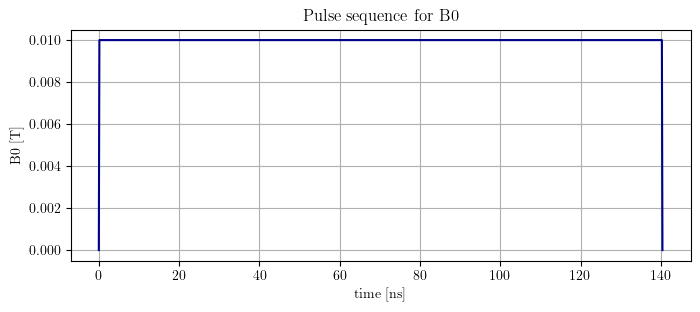

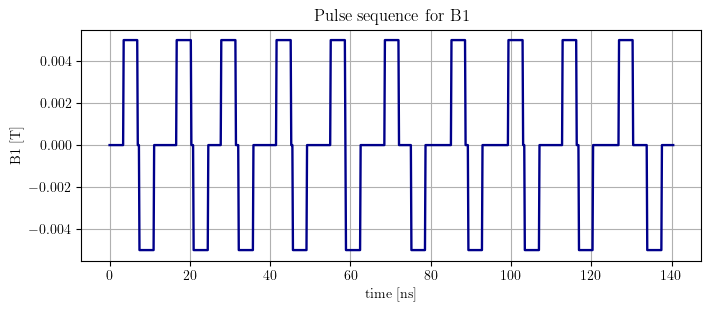

In [6]:
plot_pulses_v2(dru_circuit)

Epoch: 100%|██████████| 2/2 [00:05<00:00,  2.61s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


0


C:\Users\User\AppData\Local\Temp\ipykernel_3744\2782784827.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


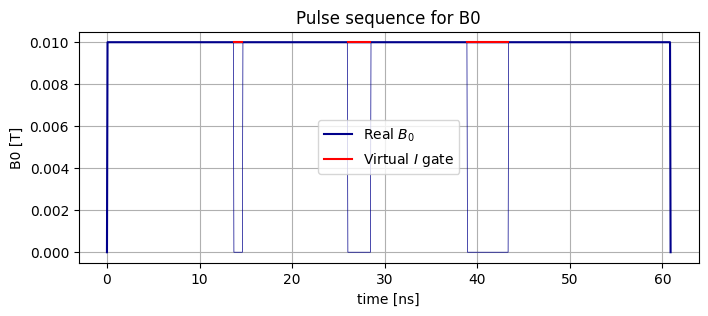

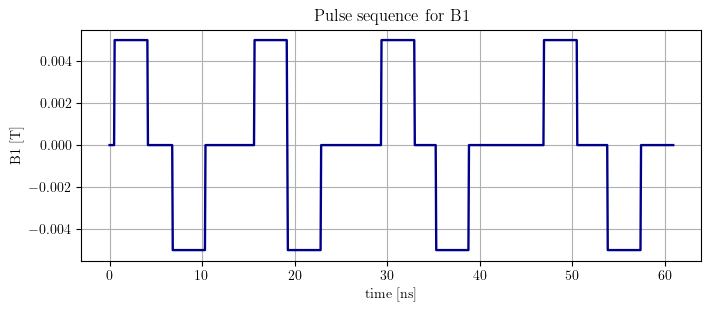

1


C:\Users\User\AppData\Local\Temp\ipykernel_3744\2782784827.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


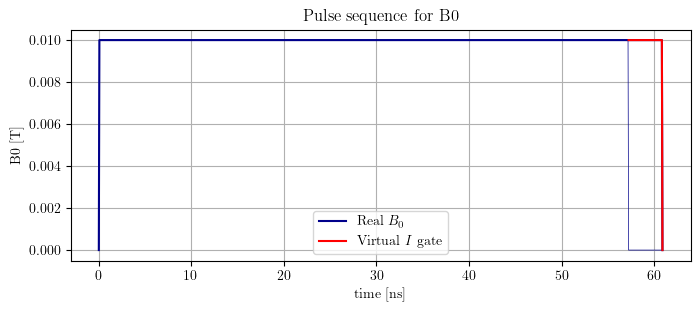

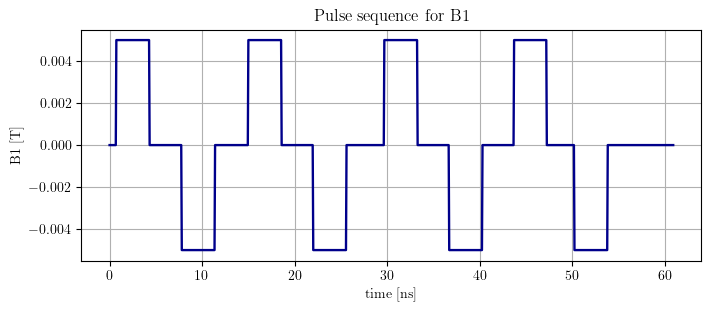

In [6]:
# 2 qubits:
X, y =  make_IRIS_v2(3,3)

tf_entanglement = False

model = Modelo_DRU(qcircuit_2_qubit_mixed, fidelity_cost,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 4, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True,
                        entanglement = tf_entanglement )

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                     save_pulses= True)

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q,
                                             entanglement = tf_entanglement)
plot_pulses_v2(dru_circuit, entangl=tf_entanglement)

Epoch: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_6352\2242180939.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


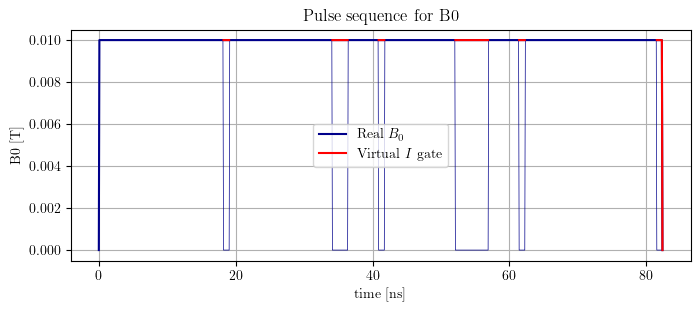

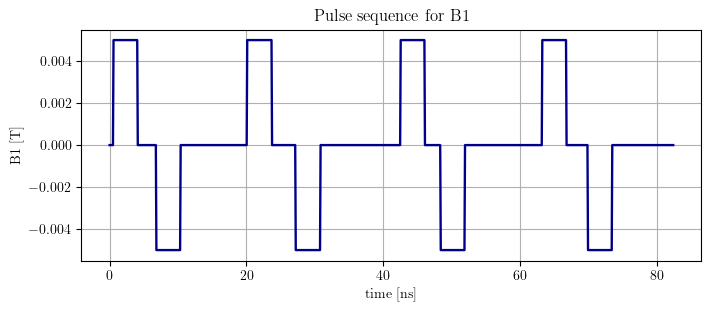

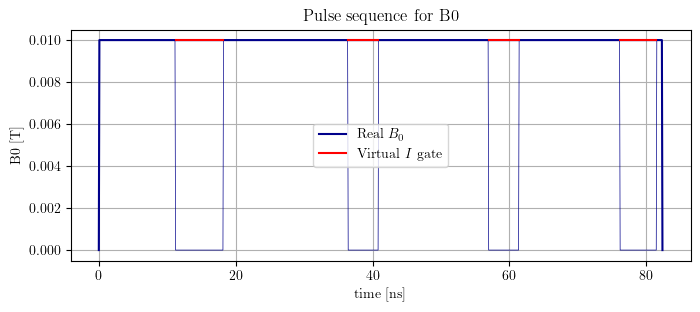

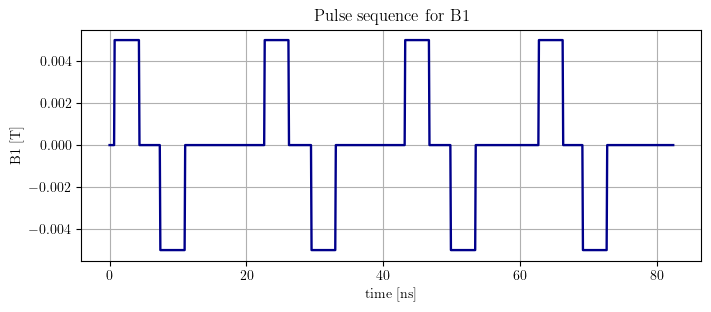

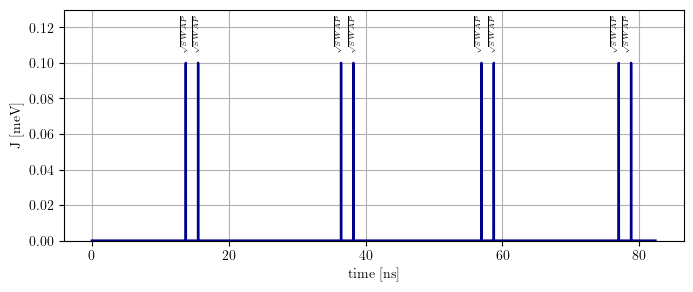

In [63]:
# 2 qubits con entrelazamiento:
X, y =  make_IRIS_v2(3,3)

tf_entanglement = True

model = Modelo_DRU(qcircuit_2_qubit_mixed, fidelity_cost,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 4, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True,
                        entanglement = tf_entanglement )

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                     save_pulses= True)

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q,
                                             entanglement = tf_entanglement)
plot_pulses_v2(dru_circuit, entangl=tf_entanglement)

Epoch: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_6352\2242180939.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


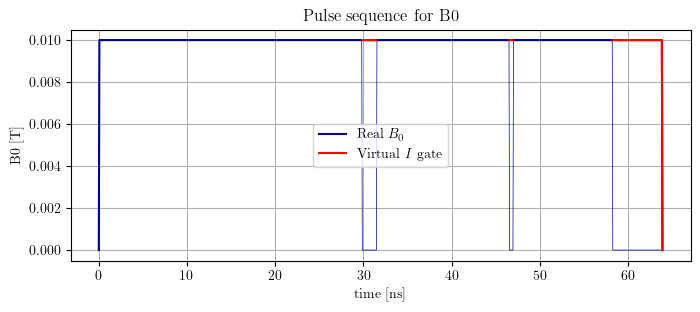

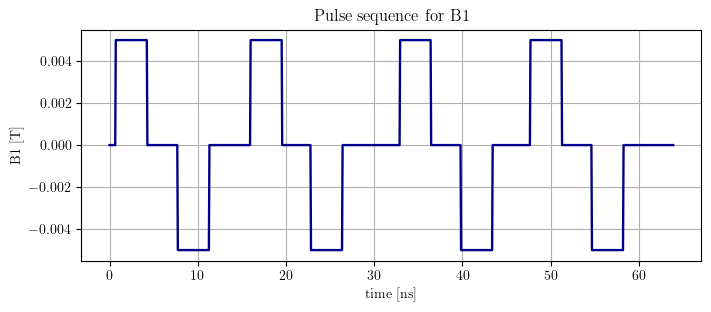

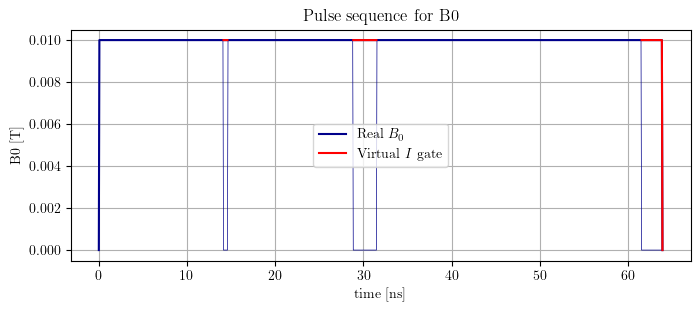

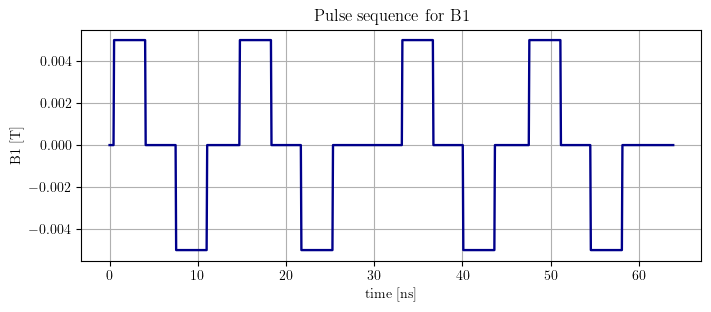

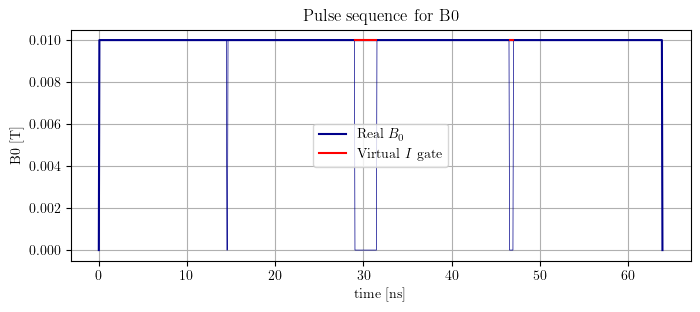

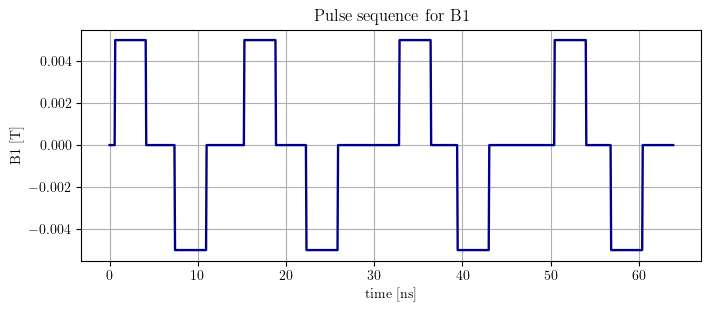

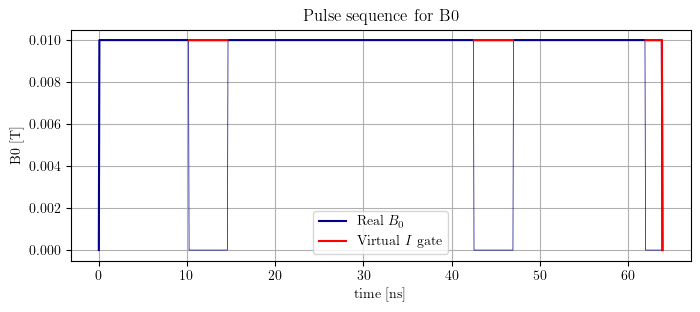

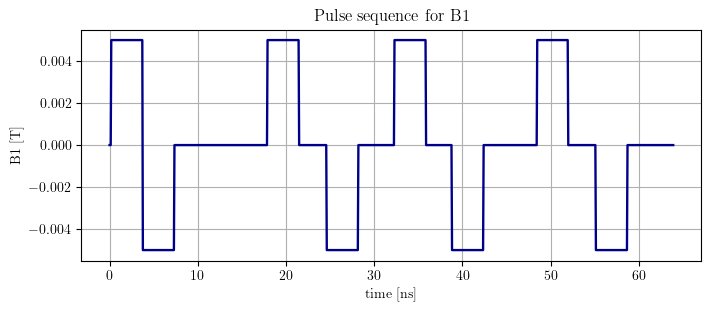

In [64]:
# 4 qubits sin entrelazamiento
X, y =  make_IRIS_v2(3,3)

tf_entanglement = False

model = Modelo_DRU(qcircuit_4_qubit_mixed, fidelity_cost,
                        epochs = 2, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = 4, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = False,
                        entanglement = tf_entanglement )

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 4,
                                     tf_noise=False,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0), basis(2, 0)),
                                     save_pulses= True)

state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_1q,
                                             model.X_val[5],
                                             bias=bias_1q,
                                             entanglement = tf_entanglement)

plot_pulses_v2(dru_circuit, entangl=tf_entanglement)

Epoch: 100%|██████████| 2/2 [00:10<00:00,  5.34s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_6352\2242180939.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


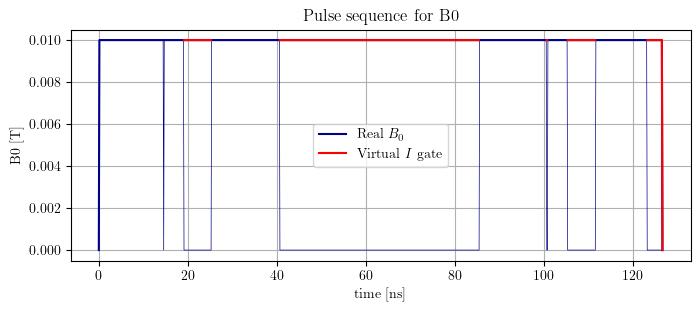

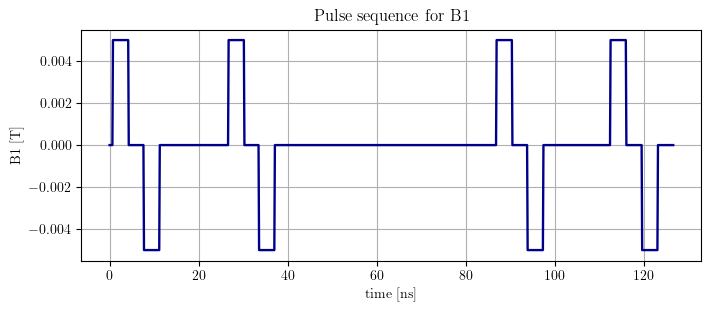

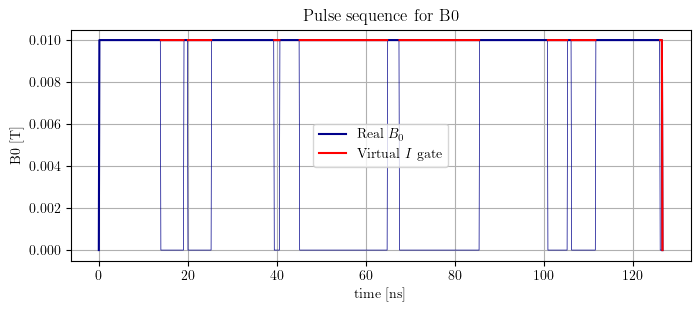

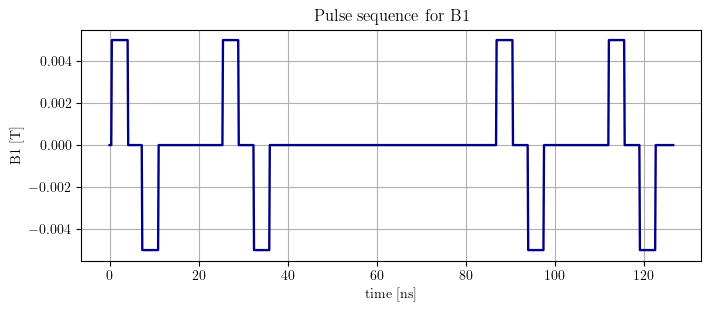

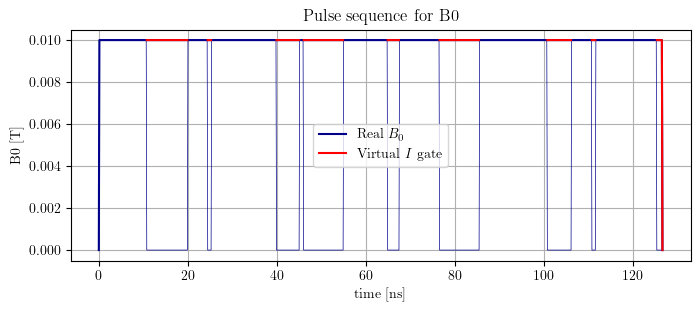

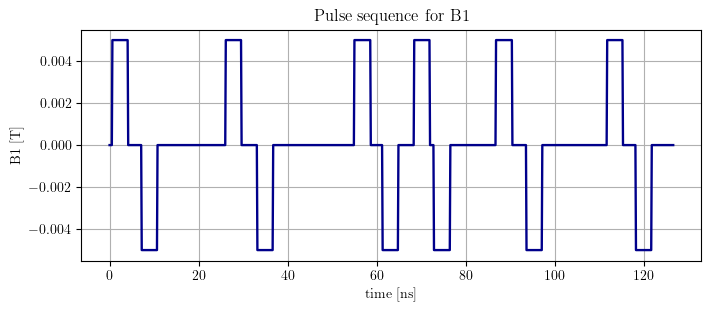

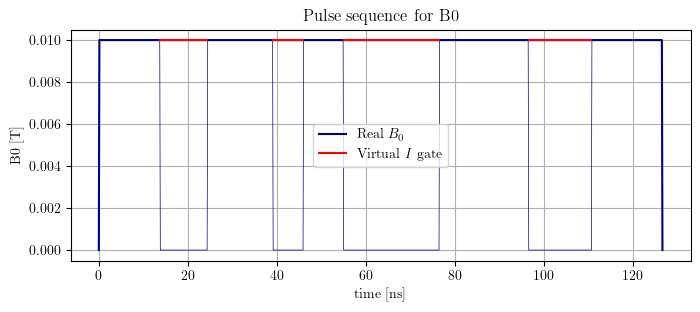

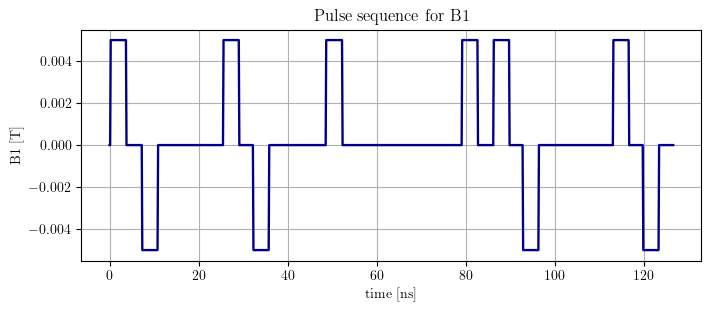

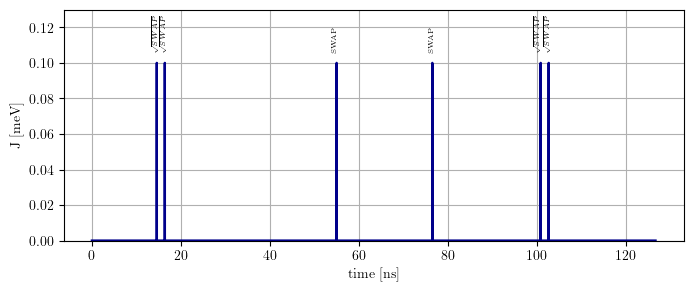

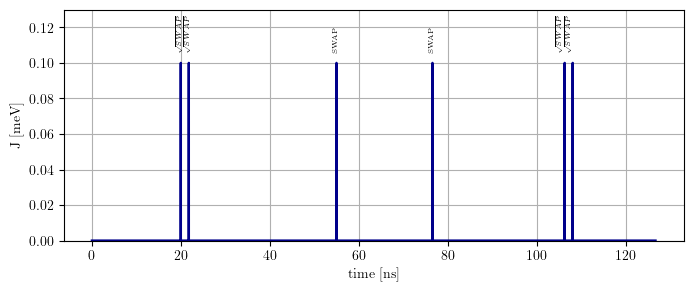

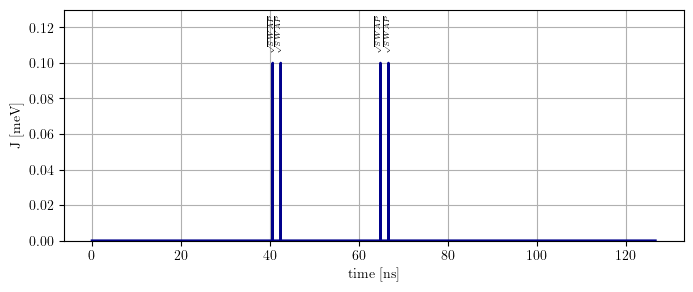

In [65]:
# 4 qubits con entrelazamiento:

X, y =  make_IRIS_v2(3,3)

tf_entanglement = True

model = Modelo_DRU(qcircuit_4_qubit_mixed, fidelity_cost,
                        epochs = 2, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = 4, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = False,
                        entanglement = tf_entanglement )

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 4,
                                     tf_noise=False,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0), basis(2, 0)),
                                     save_pulses= True)

state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_1q,
                                             model.X_val[5],
                                             bias=bias_1q,
                                             entanglement = tf_entanglement)

plot_pulses_v2(dru_circuit, entangl=tf_entanglement)
